In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import ndcg_score
from sklearn.metrics import roc_curve, auc

In [2]:
#Loads Dataset,  drop timestamp and genres form ratings.csv and movies.csv files
ratings_df = pd.read_csv('/content/drive/MyDrive/ml-latest-small/ratings.csv').drop(["timestamp"], axis=1)
movies_df = pd.read_csv('/content/drive/MyDrive/ml-latest-small/movies.csv').drop(["genres"], axis=1)

ml_df = ratings_df.merge(movies_df, on="movieId")
ml_df = ml_df.reindex(columns=["userId", "movieId", "title", "rating"])
ml_df.head() 

,userId,movieId,title,rating
0,1,1,Toy Story (1995),4.0
1,5,1,Toy Story (1995),4.0
2,7,1,Toy Story (1995),4.5
3,15,1,Toy Story (1995),2.5
4,17,1,Toy Story (1995),4.5


In [3]:
#Check for nulls
ml_df.isna().sum()

userId     0
movieId    0
title      0
rating     0
dtype: int64

In [4]:
#List unique values of each column
n_users = ml_df["userId"].max()
n_movies = ml_df["movieId"].nunique()

print("Unique Users: " + str(n_users))
print("Unique Movies: " + str(n_movies))

Unique Users: 610
Unique Movies: 9724


Preprocessing

In [5]:
#Encode ratings, encode the probability of relevance of the item for the user
ml_df["relevance"] = (ml_df["rating"] >= 5.0).astype(dtype=float)

#Set Ids as categorical data
ml_df["userId"] = ml_df["userId"].astype("category").cat.codes.values
ml_df["movieId"] = ml_df["movieId"].astype("category").cat.codes.values

ml_df.head()

,userId,movieId,title,rating,relevance
0,0,0,Toy Story (1995),4.0,0.0
1,4,0,Toy Story (1995),4.0,0.0
2,6,0,Toy Story (1995),4.5,0.0
3,14,0,Toy Story (1995),2.5,0.0
4,16,0,Toy Story (1995),4.5,0.0


In [6]:
#Shuffle Dataframe
ml_df = ml_df.sample(frac=1.0).reset_index(drop=True)
ml_df.head()

,userId,movieId,title,rating,relevance
0,482,5722,Charlie and the Chocolate Factory (2005),4.0,0.0
1,311,4135,Gangs of New York (2002),5.0,1.0
2,201,855,"Abyss, The (1989)",5.0,1.0
3,476,6239,Stranger than Fiction (2006),4.5,0.0
4,413,2019,Run Lola Run (Lola rennt) (1998),5.0,1.0


relevance number:      13211 
non-relevance number:  87625


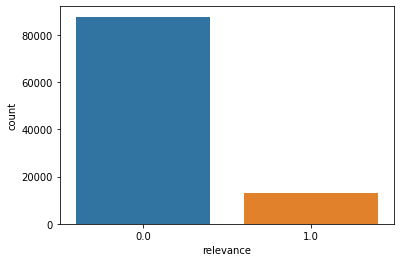

Negative Sampling Ratio: 6.632730300507153


In [7]:
#Test for negative sampling ratio
rel = (ml_df["relevance"] == 1.0).sum()
non_rel = (ml_df["relevance"] != 1.0).sum()
print("relevance number:     ", rel ,"\nnon-relevance number: ", non_rel)

sns.countplot(x="relevance", data=ml_df)
plt.show()
print("Negative Sampling Ratio: " + str(non_rel / rel))

Split eval, test , train

In [8]:
#Split dataset between train, eval and test
full_df = ml_df
eval_df = full_df.sample(frac=0.05)
full_df = full_df.drop(eval_df.index)
test_df = full_df.sample(frac=0.05)
train_df = full_df.drop(test_df.index)

In [9]:
#Store number of datapoints in each dataset
train_count = train_df.shape[0]
eval_count = eval_df.shape[0]
test_count = test_df.shape[0]
print("Train samples: " + str(train_count))
print("Evaluation samples: " + str(eval_count))
print("Test samples: " + str(test_count))
train_df.head()

Train samples: 91004
Evaluation samples: 5042
Test samples: 4790


,userId,movieId,title,rating,relevance
0,482,5722,Charlie and the Chocolate Factory (2005),4.0,0.0
2,201,855,"Abyss, The (1989)",5.0,1.0
3,476,6239,Stranger than Fiction (2006),4.5,0.0
4,413,2019,Run Lola Run (Lola rennt) (1998),5.0,1.0
5,56,2794,Big Trouble in Little China (1986),4.0,0.0


In [10]:
#Create Datasets for train, evaluation and testing
train_ds = tf.data.Dataset.from_tensor_slices(({"userId":train_df["userId"],
                                                "movieId":train_df["movieId"]},
                                                train_df["relevance"].values.reshape([-1, 1]))).shuffle(4196)

eval_ds = tf.data.Dataset.from_tensor_slices(({"userId":eval_df["userId"],
                                               "movieId":eval_df["movieId"]},
                                               eval_df["relevance"].values.reshape([-1, 1]))).batch(eval_count)

test_ds = tf.data.Dataset.from_tensor_slices(({"userId":test_df["userId"],
                                               "movieId":test_df["movieId"]}, 
                                               test_df["relevance"].values.reshape([-1, 1]))).batch(test_count)

Neural collaborative filtering

In [11]:
class DenseBlock(tf.keras.layers.Layer):

  def __init__(self, units, activation="relu", dropout=0.1, l2=0.001):  
    super(DenseBlock, self).__init__()

    self.bn = tf.keras.layers.BatchNormalization()
    self.drop = tf.keras.layers.Dropout(dropout)
    self.dense = tf.keras.layers.Dense(units, 
                                       activation,
                                       kernel_regularizer=tf.keras.regularizers.L1L2(l2=l2),
                                       kernel_constraint=tf.keras.constraints.UnitNorm())
    
  def call(self, inputs):
    X = self.bn(inputs)
    X = self.drop(X)
    X = self.dense(X)
    return X

In [12]:
class DeepFeedForward(tf.keras.Model):

  def __init__(self, layers, dropout=0.1, l2=0.001):
    super(DeepFeedForward, self).__init__()

    self.block_list = list()
    for layer in layers:
      self.block_list.append(DenseBlock(layer, "relu", dropout, l2))
    
  def call(self, inputs):
    X = inputs
    for layer in self.block_list:
      X = layer(X)
    return X

In [13]:
class NCFNetwork(tf.keras.Model):

  def __init__(self, 
               alpha_dim, 
               beta_dim, 
               latent_dim, 
               layers, 
               output_activation="sigmoid",
               use_bias=False, 
               dropout=0.1, 
               l2=0.001, 
               alpha_key="alpha", 
               beta_key="beta"):
    
    super(NCFNetwork, self).__init__() 

    self.alpha_key = alpha_key
    self.beta_key = beta_key
    self.use_bias = use_bias

    self.alpha_emb = tf.keras.layers.Embedding(alpha_dim, latent_dim, 
                                               embeddings_regularizer=tf.keras.regularizers.L1L2(l2=l2))
    self.beta_emb = tf.keras.layers.Embedding(beta_dim, latent_dim,
                                               embeddings_regularizer=tf.keras.regularizers.L1L2(l2=l2))

    if(use_bias):
      self.alpha_bias = tf.keras.layers.Embedding(alpha_dim, 1)
      self.beta_bias = tf.keras.layers.Embedding(beta_dim, 1)
    
    self.flat = tf.keras.layers.Flatten()
    self.feedforward = DeepFeedForward(layers[:-1], dropout, l2)
    self.dense_out = DenseBlock(layers[-1], output_activation, dropout, l2)

  def call(self, inputs):

    alpha_emb = self.flat(self.alpha_emb(inputs[self.alpha_key]))
    beta_emb = self.flat(self.beta_emb(inputs[self.beta_key]))
    X = tf.concat([alpha_emb, beta_emb], axis=-1)

    if(self.use_bias):
      alpha_bias = self.flat(self.alpha_bias(inputs[self.alpha_key]))
      beta_bias = self.flat(self.beta_bias(inputs[self.beta_key]))
      bias = tf.add(alpha_bias, beta_bias)
      X = tf.add(X, bias)

    X = self.feedforward(X)
    X = self.dense_out(X)
    return X

In [14]:
#Hyper parameters
ncf_params = {"alpha_dim":n_users,
              "beta_dim":n_movies,
              "latent_dim":8,                   #[8, 16, 32, 64]
              "layers":[32, 16, 8, 1],
              "output_activation":"sigmoid",
              "use_bias":False,
              "dropout":0.4,
              "l2":0.001,
              "learning_rate":0.001,            #[0.0001, 0.0005, 0.001, 0.005]
              "batch_size":256,                 #[128, 256, 512, 1024]
              "epochs":50}

In [41]:
#Instantiation
ncf = NCFNetwork(alpha_dim=ncf_params["alpha_dim"], 
                 beta_dim=ncf_params["beta_dim"], 
                 latent_dim=ncf_params["latent_dim"], 
                 layers=ncf_params["layers"],
                 output_activation=ncf_params["output_activation"],
                 use_bias=ncf_params["use_bias"],
                 dropout=ncf_params["dropout"], 
                 l2=ncf_params["l2"], 
                 alpha_key="userId",
                 beta_key="movieId")


METRICS = [tf.keras.metrics.BinaryAccuracy(), 
           tf.keras.metrics.TruePositives(name='tp'),
           tf.keras.metrics.FalsePositives(name='fp'), 
           tf.keras.metrics.TrueNegatives(name='tn'),
           tf.keras.metrics.FalseNegatives(name='fn'),  
           tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc'),
           tf.keras.metrics.AUC(curve='ROC')]

ncf.compile(tf.keras.optimizers.Adam(ncf_params["learning_rate"]), 
            tf.keras.losses.BinaryCrossentropy(),metrics=METRICS)


In [42]:
#Fitting
history= ncf.fit(train_ds.batch(ncf_params["batch_size"]), 
                 epochs=ncf_params["epochs"], 
                 validation_data=eval_ds, 
                 callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])


Epoch 1/50
356/356 [==============================] - 6s 8ms/step - loss: 0.6969 - binary_accuracy: 0.7073 - tp: 3066.0000 - fp: 17778.0000 - tn: 61304.0000 - fn: 8856.0000 - accuracy: 0.7073 - precision: 0.1471 - recall: 0.2572 - auc: 0.5239 - auc_7: 0.5239 - val_loss: 0.4959 - val_binary_accuracy: 0.8673 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 4373.0000 - val_fn: 669.0000 - val_accuracy: 0.8673 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5484 - val_auc_7: 0.5484
Epoch 2/50
356/356 [==============================] - 2s 5ms/step - loss: 0.5073 - binary_accuracy: 0.8523 - tp: 582.0000 - fp: 2103.0000 - tn: 76979.0000 - fn: 11340.0000 - accuracy: 0.8523 - precision: 0.2168 - recall: 0.0488 - auc: 0.5386 - auc_7: 0.5386 - val_loss: 0.4507 - val_binary_accuracy: 0.8673 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 4373.0000 - val_fn: 669.0000 - val_accuracy: 0.8673 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7081 - val_auc_7: 0.

In [61]:
ncf.evaluate(test_ds)

1/1 [==============================] - 0s 37ms/step - loss: 0.3840 - binary_accuracy: 0.8747 - tp: 28.0000 - fp: 8.0000 - tn: 4162.0000 - fn: 592.0000 - accuracy: 0.8747 - precision: 0.7778 - recall: 0.0452 - auc: 0.8195 - auc_7: 0.8195


[0.38402432203292847,
 0.8747390508651733,
 28.0,
 8.0,
 4162.0,
 592.0,
 0.8747390508651733,
 0.7777777910232544,
 0.04516129195690155,
 0.8194742202758789,
 0.8194742202758789]

In [57]:
confusion_Matrix=[[history.history['tn'][-1],history.history['fp'][-1]],
                  [history.history['fn'][-1],history.history['tp'][-1]]]
print("confusion_Matrix", confusion_Matrix)

confusion_Matrix [[78175.0, 907.0], [10848.0, 1074.0]]


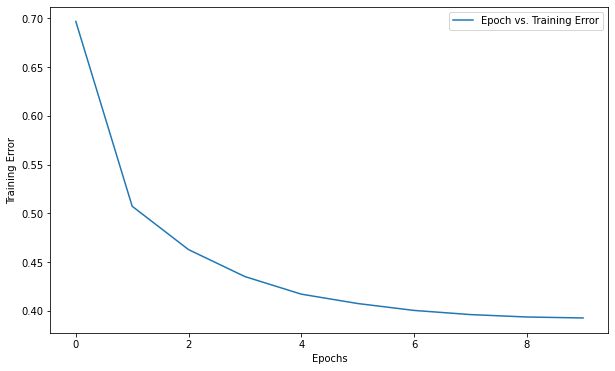

In [62]:
plt.figure(figsize=(10,6)) 
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")
plt.legend(["Epoch vs. Training Error"])
plt.show()

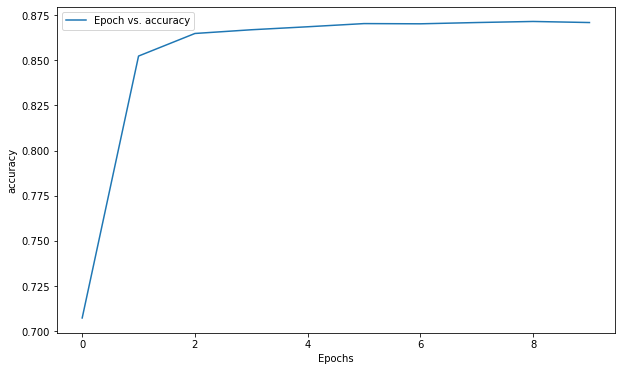

In [63]:
plt.figure(figsize=(10,6)) 
plt.plot(history.history['binary_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend(["Epoch vs. accuracy"])
plt.show()

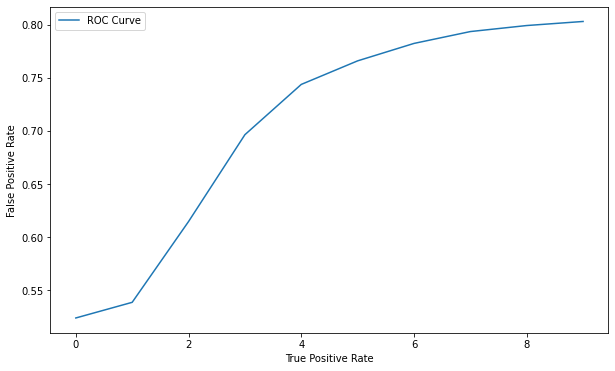

In [59]:
plt.figure(figsize=(10,6)) 
plt.plot(history.history['auc'])
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.legend(["ROC Curve"])
plt.show()

In [ ]:
# Let us get a user and see the top recommendations.
user_id = ml_df.userId.sample(1).iloc[0]

movies_watched_by_user = ml_df[ml_df.userId == user_id]
movies_not_watched = movies_df[~movies_df["movieId"].isin(movies_watched_by_user.movieId.values)]["movieId"]

movie_ids = movies_df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movies_not_watched = list(set(movies_not_watched).intersection(set(movie2movie_encoded.keys())) )
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]

user_ids = ml_df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(([[user_encoder]] * len(movies_not_watched), movies_not_watched))

ratings = ncf.predict(user_movie_array).flatten() 
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)

top_movies_user = (movies_watched_by_user.sort_values(by="rating", ascending=False).head(5).movieId.values)
movies_df_rows = movies_df[movies_df["movieId"].isin(top_movies_user)]

for row in movies_df_rows.itertuples():
    print(row.title, ":", row.genres)
print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)

recommended_movies = movies_df[movies_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)